## **Deep Learning Models for Image Classification**

#### `Name & Surname: Abdulkadir Arslan`

## **The Packages:**

In [1]:
import torch
import random
import numpy as np

##Setting seeds globally at the beginning of the notebook for reproducibility##
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seeds()
##Setting seeds globally at the beginning of the notebook for reproducibility##

import zipfile
import tarfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as T
from torch.utils.data.dataloader import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from collections import Counter
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

## **1. TASK 1 - STORY**

<div class="alert alert-block alert-info">
<b>A Fictitious Situation:</b>

In a coastal city that's growing fast, the Environmental Monitoring Agency (EMA) faces a big job: keeping track of how the city is changing and how the environment is doing. As a data scientist at EMA, my job was to use deep learning to figure out what's in satellite images from the RSI-CB256 (Satellite image Classification Dataset).

Our goal was simple: create a model that can sort images into four groups—'cloudy', 'desert', 'green areas', and 'water'. These groups help EMA watch for things like urban heat spots, water quality, and changes in plants.

We started by getting the dataset ready and making sure our model could handle all kinds of weather and other conditions. Using high-tech deep learning tricks, we taught the model to tell the groups apart accurately.

If our model works well, EMA can quickly see how the environment is changing. This helps city planning and efforts to protect nature in our growing city.

## **2. TASK 2 - THE DATA**

[SOURCE OF THE DATA (www.kaggle.com)](https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification)

###### I also provided the data file itself because the website asks for signing-in unless you do not have an account.

In [2]:
with zipfile.ZipFile('archive.zip', 'r') as zipped_archive:
    zipped_archive.extractall(path='./data')

img_data_dir = './data/data'
folder_names = {0: 'cloudy', 1: 'desert', 2: 'green_area', 3: 'water'}

data_summary = []

for key in folder_names:
    folder_name = folder_names[key]
    files_in_folder = os.listdir(os.path.join(img_data_dir, folder_name))
    total_images = len(files_in_folder)
    data_summary.append({'folder_name(class)': folder_name, 'total_image': total_images})

total_images_all = sum(summary['total_image'] for summary in data_summary)

data_summary.append({'folder_name(class)': 'Total', 'total_image': total_images_all})

print("The number of images by the identical folder names in the dataset:\n")
pd.DataFrame(data_summary)


The number of images by the identical folder names in the dataset:



,folder_name(class),total_image
0,cloudy,1500
1,desert,1131
2,green_area,1500
3,water,1500
4,Total,5631


<div class="alert alert-block alert-info">
<b>Data Explanation:</b>

The RSI-CB256 dataset comprises satellite images sourced from sensors and Google Maps snapshots. It features four distinct classes: `cloudy`, `desert`, `green_area` and `water`. These images are instrumental in remote sensing applications, aiding in the automated interpretation of environmental features such as weather conditions, land cover types (like deserts and green areas), and water bodies. The dataset serves as a benchmark for developing and testing intelligent algorithms in remote sensing image interpretation.

- The names of the image folders in the 'data' folder correspond exactly to the names of the images they include so each class of data images is stored in separate folders.


**The Dataset Suitablity:**:

These images serve as valuable resources for training deep learning models in remote sensing applications, enabling accurate classification of environmental features and urban landscapes.

  - The data directory structure, individual folders per image class, is widely used in many computer vision datasets, and most deep learning libraries have tools to work with these datasets and the ImageFolder class from torchvision can be used to load the data as PyTorch tensors.
  
  - For optimal deep learning experiments, it's important that the data is evenly balanced to ensure accurate final predictions. However, all classes contain 1500 images except for the desert class, which has 1131 images.

## **3. TASK 3 - IDA**

In the initial analysis task, below, I first visualized the first image from each class and divided these images into Red, Green, and Blue bands later I computed and plotted the average pixel values of all the images by class and color band. The interpretation of the outputs from these visualitaions is existing at the end of the Task 3.

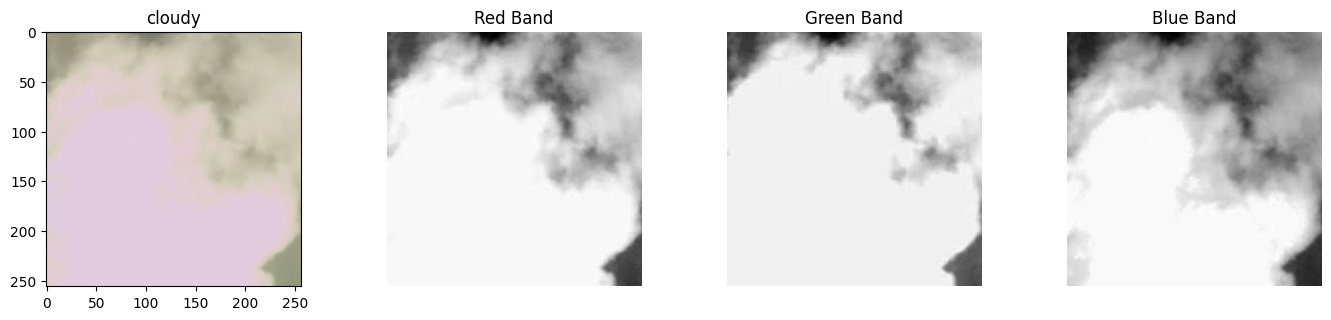

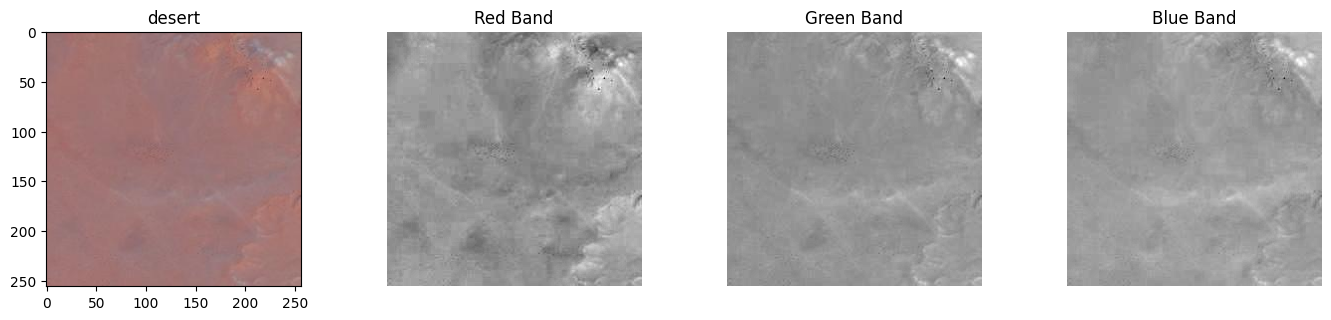

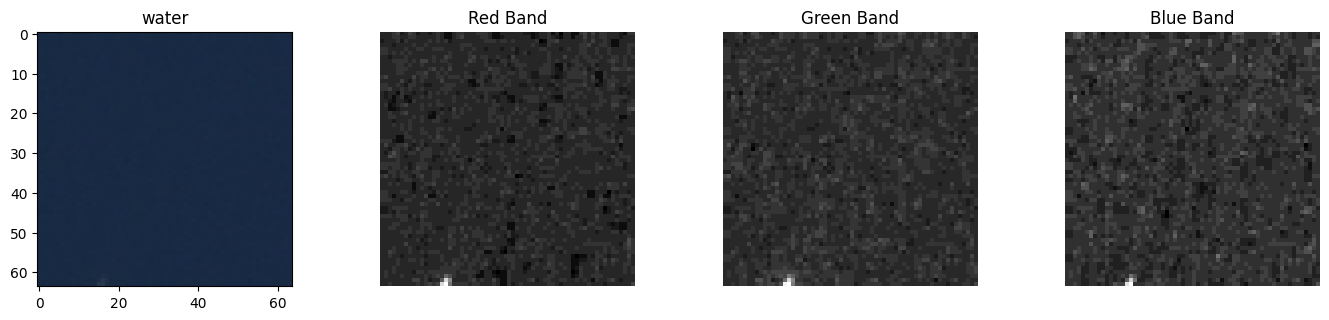

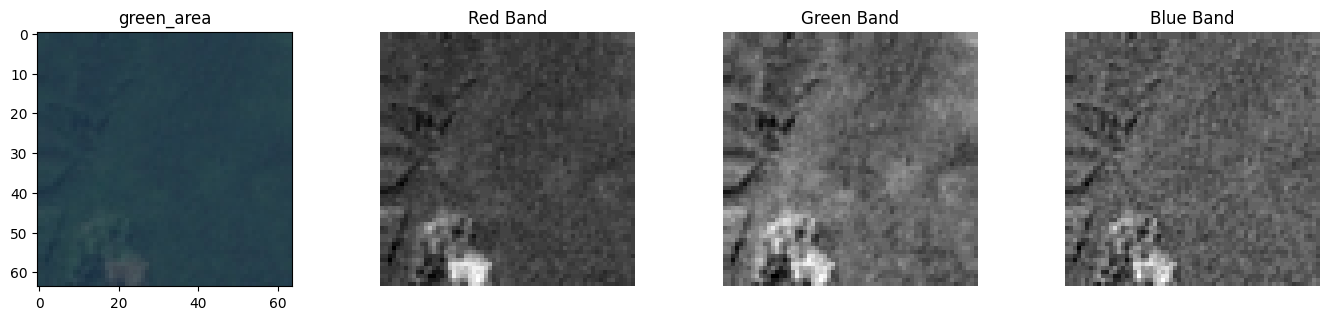

In [3]:
def plot_first_images(each_folder):
    plt.figure(figsize=(14, 6))
    
    folder_path = img_data_dir + each_folder
    files = os.listdir(folder_path)
    first_img = files[0] 
    
    img = mpimg.imread(os.path.join(folder_path, first_img))
    
    plt.subplot(2, 4, 1)
    plt.imshow(img)
    plt.title(each_folder[1:])

    for i, color in enumerate(['Red', 'Green', 'Blue']):
        band = img[:, :, i]
        plt.subplot(2, 4, i + 2)
        plt.imshow(band, cmap='gray')
        plt.title(color + ' Band')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_first_images('/cloudy')
plot_first_images('/desert')
plot_first_images('/water')
plot_first_images('/green_area')


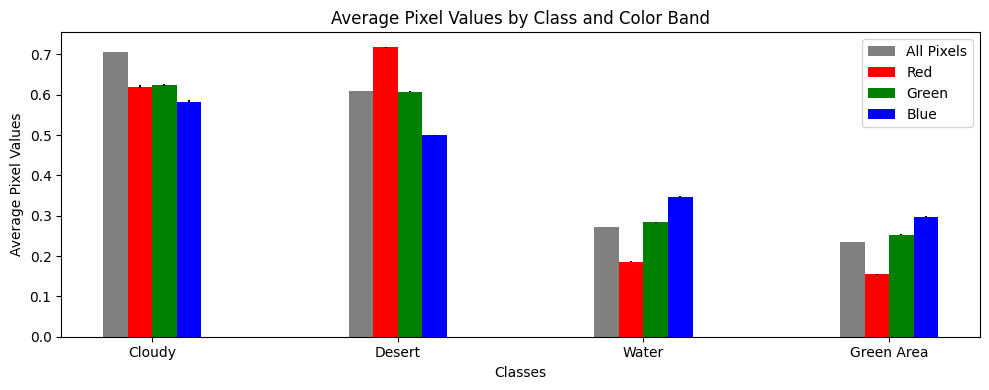

In [4]:
def compute_statistics(each_folder):
    image_files = os.listdir(img_data_dir + each_folder)

    avg_class = None
    count = 0
    for i in range(len(image_files)):
        count += 1
        img = mpimg.imread(img_data_dir + each_folder + '/' + image_files[i])
        if avg_class is None:
            avg_class = np.zeros_like(img, dtype=np.float64)
        avg_class += img.astype(np.float64)

    avg_class /= count

    avg_all_pixels = np.mean(avg_class / 255)  # Average pixel values of all pixels
    avg_pixel_values = np.mean(avg_class[:, :, 0:3] / 255, axis=(0, 1))  # Average pixel values per RGB band
    std_pixel_values = np.std(avg_class[:, :, 0:3] / 255, axis=(0, 1))   # Standard deviation per RGB band
    
    return avg_all_pixels, avg_pixel_values, std_pixel_values

img_folders = ['/cloudy', '/desert', '/water', '/green_area']
labels = ['Cloudy', 'Desert', 'Water', 'Green Area']
colors = ['Red', 'Green', 'Blue']

avg_all_pixels_values = []
avg_values = []
std_values = []

for each_folder in img_folders:
    avg_all_pixels, avg_pixel_values, std_pixel_values = compute_statistics(each_folder)
    avg_all_pixels_values.append(avg_all_pixels)
    avg_values.append(avg_pixel_values)
    std_values.append(std_pixel_values)

avg_all_pixels_values = np.array(avg_all_pixels_values)
avg_values = np.array(avg_values)
std_values = np.array(std_values)

x = np.arange(len(labels))  
width = 0.1 

fig, ax = plt.subplots(figsize=(10, 4))

rects0 = ax.bar(x - 1.5*width, avg_all_pixels_values, width, label='All Pixels', color='gray')

rects1 = ax.bar(x - 0.5*width, avg_values[:, 0], width, label='Red', yerr=std_values[:, 0], color='r')
rects2 = ax.bar(x + 0.5*width, avg_values[:, 1], width, label='Green', yerr=std_values[:, 1], color='g')
rects3 = ax.bar(x + 1.5*width, avg_values[:, 2], width, label='Blue', yerr=std_values[:, 2], color='b')

ax.set_xlabel('Classes')
ax.set_ylabel('Average Pixel Values')
ax.set_title('Average Pixel Values by Class and Color Band')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


<div class="alert alert-block alert-info">
<b>Initial Data Analysis Report:</b>

- The first images have been chosen from each class and plotted to have an idea about how images look like and what are the sizes and resolutions. When the firsts are taken as a reference, the images seem interpretable according to their classes.

- Pixel sizes range from 0 to 255, with cloudy and desert having higher pixel values compared to water and green areas. The size of cloudy and desert images are 256X256 the size of water and green_area images are 64X64.

- Dividing images into Red, Green, and Blue bands allows for accurate color representation and detailed analysis, as each band highlights different features. For example, the cloudy image is slightly clearer on the Blue band and green_area image on the Green band

- The average pixel values vary across images; the cloudy image exhibits the highest values, akin to those of the desert image, while the green_area image shows the lowest values, similar to those of the water image. The desert image has the highest average pixel value in the red band and the water image in the blue band as expected but the values of cloudy and green_area images are unexpected. However, it might change based on different images.

## **4. TASK 4 - EDA, Preprocessing**

i. Loading the Dataset with 'ImageFolder':

- 'ImageFolder' simplifies loading datasets organized in a folder structure by automatically assigning labels based on folder names.
- 'ToTensor(), CenterCrop(64), and Resize(64)' are transformations applied to ensure all images are in a consistent format (tensor format, cropped, and resized) before further processing.


In [5]:
img_data = ImageFolder(img_data_dir+'/', transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                T.CenterCrop(64),
                                                                                T.Resize(64)]))

ii. Using 'DataLoader' for Preprocessing:
- 'DataLoader' efficiently loads data in batches, which is crucial for large datasets to manage memory usage and enable batch processing during training or analysis.


In [6]:
img_data_loader = DataLoader(
    img_data,
    batch_size=len(img_data),
    shuffle=False,
    num_workers=0)

iii. Calculating Mean and Standard Deviation:
- I created a function to compute the mean and standard deviation of pixel values across all images in the dataset. Calculating mean and standard deviation helps in normalizing the dataset before training deep learning models. Normalization improves model convergence and performance by scaling input data to a standard range.

In [7]:
def mean_std_dev(loader):
    images, labels = next(iter(loader))
    mean, std = images.mean([0, 2, 3]), images.std([0, 2, 3])
    return mean, std

mean, std = mean_std_dev(img_data_loader)
print(" mean and standard deviation values: \n\n", mean, std)


 mean and standard deviation values: 

 tensor([0.4014, 0.4324, 0.4288]) tensor([0.2662, 0.1998, 0.1473])


iv. Transorming the image dataset into Tensor Format and applying Normalization using the calclutated mean and standart values above:

- By defining and applying these transformations, the code prepares the dataset for training deep learning models effectively. This preprocessing step ensures that the input data is normalized and standardized, which can lead to better model performance and convergence during training.

In [8]:
mean = [0.4014, 0.4324, 0.4288]
std = [0.2662, 0.1998, 0.1473]

transform = T.Compose([
    T.Resize(64),             
    T.CenterCrop(64),           
    T.ToTensor(),               
    T.Normalize(mean=mean, std=std)  
])

img_dataset = torchvision.datasets.ImageFolder(root=img_data_dir+'/',transform=transform)
print (img_dataset)

Dataset ImageFolder
    Number of datapoints: 5631
    Root location: ./data/data/
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=[0.4014, 0.4324, 0.4288], std=[0.2662, 0.1998, 0.1473])
           )


v. Displaying the Transformation Progress upon the first image:
- Visualizing the images and understanding their distribution helps in ensuring that the data is correctly preprocessed and ready for training.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009158195..3.0791104].


Class Label: cloudy
Image Shape: torch.Size([3, 64, 64])


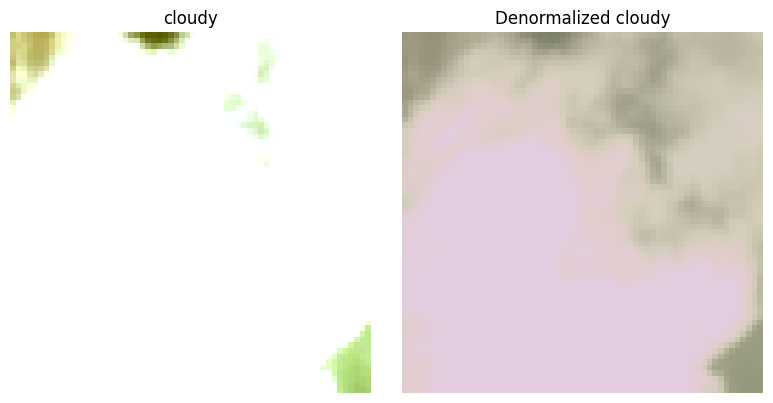

In [9]:
first_img, first_img_label = img_dataset[0]
print(f"Class Label: {folder_names[first_img_label]}")
print(f"Image Shape: {first_img.shape}")

mean_norm = torch.tensor([0.4014, 0.4324, 0.4288]).view(3, 1, 1)
std_norm = torch.tensor([0.2662, 0.1998, 0.1473]).view(3, 1, 1)


def de_norm(img_tensor, mean, std):
    return img_tensor * std + mean

de_norm_img = de_norm(first_img, mean_norm, std_norm)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(first_img.permute(1, 2, 0))
axs[0].set_title(folder_names[first_img_label])
axs[0].axis('off')

axs[1].imshow(de_norm_img.permute(1, 2, 0))
axs[1].set_title(f"Denormalized {folder_names[first_img_label]}")
axs[1].axis('off')

plt.tight_layout()
plt.show()

vi.Splitting the dataset into Training, Validation, and Testing sets for conducting Deep Learning Experiments:
- Splitting the dataset into training, validation, and testing sets ensures that the model learns from a dedicated portion of the data(training), tunes its hyperparameters on a separate set(validation) to avoid overfitting, and is finally evaluated on an independent set(testing) to assess its generalization performance.
- My dataset has 5631 samples so it is not big enough for the deep learning experiments. Therefore, I decided to train a large part of the samples (85%) and select a small portion for testing(5%) and reasonable part for the validation (10%) and split them randomly.
- I set the betch size as 20 (a typical value) for loading the splitted datasets in DataLoader.

In [10]:
val_size_dl = int(len(img_dataset)*0.10)
test_size_dl = int(len(img_dataset)*0.05)
train_size_dl = len(img_dataset) - val_size_dl - test_size_dl

train_dataset, val_dataset, test_dataset = random_split(img_dataset, [train_size_dl, val_size_dl, test_size_dl])

print(f'Training set size: {train_size_dl} samples')
print(f'Validation set size: {val_size_dl} samples')
print(f'Test set size: {test_size_dl} samples')

train_deep = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=0)
val_deep = DataLoader(val_dataset, batch_size=20, shuffle=False, num_workers=0)

Training set size: 4787 samples
Validation set size: 563 samples
Test set size: 281 samples


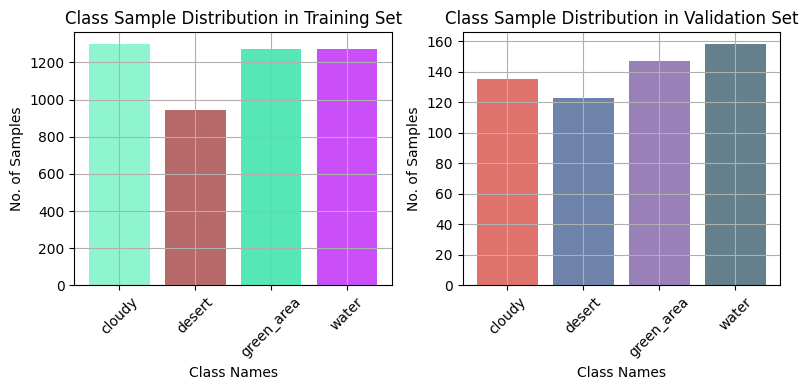

In [11]:
classes = ['cloudy', 'desert', 'green_area', 'water'] 

def plot_dataset_class_dist(data_loader, title, classes, ax):

    labels = [label for _, label in data_loader.dataset]
    
    label_counts = np.bincount(labels)
    
    ax.bar(np.arange(len(label_counts)), label_counts, alpha=0.7, color=get_bar_colors(len(classes)))
    ax.set_xlabel('Class Names')
    ax.set_ylabel('No. of Samples')
    ax.set_title('Class Sample Distribution in ' + title)
    ax.set_xticks(np.arange(len(classes)))  
    ax.set_xticklabels(classes, rotation=45)  
    ax.grid(True)

def get_bar_colors(num_classes):
    return np.random.rand(num_classes, 3)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

plot_dataset_class_dist(train_deep, 'Training Set', classes, ax=axs[0])

plot_dataset_class_dist(val_deep, 'Validation Set', classes, ax=axs[1])

plt.tight_layout()
plt.show()


vii. Displaying the Transformation Progress upon the First Batch of Images from Training Dataset:

Batch Images Shape: torch.Size([20, 3, 64, 64])


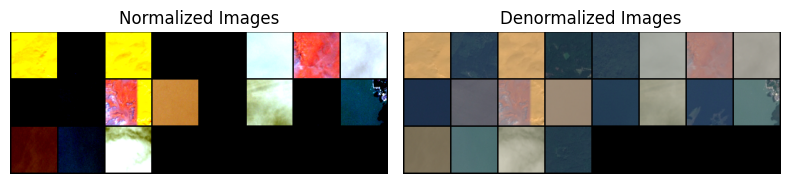

In [12]:
def show_denormalized_images(images, mean, std):
    denorm_images = de_norm(images, mean, std)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 8))
    
    axs[0].imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0, 1))
    axs[0].set_title('Normalized Images')
    axs[0].axis('off')
    
    axs[1].imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0, 1))
    axs[1].set_title('Denormalized Images')
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()

for images, labels in train_deep:
    print(f"Batch Images Shape: {images.shape}")
    break

show_denormalized_images(images, mean_norm, std_norm)


<div class="alert alert-block alert-info">
<b>EDA and Preprocessing Report:</b>

- The images have been converted into tensor format and applied data normalization.

- The dataset contains 5631 images and I have included all images without filtering based on their quantity, dimensions, or anomalies at the beginning.

- The entire dataset was splitted into training (85%), validation (10%), and testing (5%) sets for conducting Deep Learning Experiments, using a typical batch size of 20. 

- Upon visualizing the first batch of training data, it is evident that normalization has caused more than half of the images to appear very dark. Nevertheless, normalization has significantly enhanced the visibility of some image classes, particularly cloudy. This demonstrates the effectiveness of the normalization process in enhancing specific image characteristics.

## **5. TASK 5 - BASELINES**

i. Data preparation for the Baselines:
- Again Transorming the image dataset into Tensor Format but this time limiting it only with 'Resize' and 'CenterCrop' because these transformations strike a balance between simplicity, consistency, and initial preprocessing requirements, setting a solid foundation for further data analysis and model development.

In [13]:
baseline_dataset = torchvision.datasets.ImageFolder(root=img_data_dir+'/',transform=T.Compose([T.Resize(64),T.CenterCrop(64)]))

ii. Splitting the "baseline__dataset" into Training and Test sets:
- To create separate datasets for training the model and test its performance, ensuring the model is evaluated on data it has not seen during training.
- The dataset is split randomly into training (90%) and test (10%) sets.

In [14]:
test_size_ml = int(len(img_dataset)*0.10)
train_size_ml = len(img_dataset) - test_size_ml

train_baseline, test_baseline = random_split(baseline_dataset,[train_size_ml, test_size_ml])

iii. Normalization and Reshaping:
- The images are converted into numpy arrays and normalized by dividing by 255, which scales the pixel values to the range [0, 1]. Scaling the pixel values ensures that the data is in a suitable range for many machine learning algorithms.
- Classical machine learning algorithms generally expect 2D input arrays where each row represents a sample and each column represents a feature. Here, each image (64x64 pixels with 3 color channels) is flattened into a single row with 12288 features (64643).

In [15]:
train_baseline_norm, train_baseline_label = [], []
test_baseline_norm, test_baseline_label = [], []

def preprocess_images_ml(dataset, x_list, y_list):
    for data, label in dataset:
        # Convert image data to numpy array and normalize pixel values
        image_array = np.array(data) / 255.0  
        x_list.append(image_array)
        y_list.append(label)

preprocess_images_ml(train_baseline, train_baseline_norm, train_baseline_label)

# Convert lists to numpy arrays
train_baseline_norm = np.array(train_baseline_norm)

print('3D training dataset shape:', train_baseline_norm.shape)

# Reshape the training dataset into 2D arrays
data_num, x_ax, y_ax, z_ax = train_baseline_norm.shape
x_train_norm = train_baseline_norm.reshape((data_num, x_ax * y_ax * z_ax))

print('2D training dataset shape:', x_train_norm.shape)

preprocess_images_ml(test_baseline, test_baseline_norm, test_baseline_label)

test_baseline_norm = np.array(test_baseline_norm)
print ('3D test dataset shape:',test_baseline_norm.shape)

data_num, x_ax, y_ax, z_ax = test_baseline_norm.shape
x_test_norm = test_baseline_norm.reshape((data_num,x_ax*y_ax*z_ax))

print ('2D test dataset shape:', x_test_norm.shape)


3D training dataset shape: (5068, 64, 64, 3)
2D training dataset shape: (5068, 12288)
3D test dataset shape: (563, 64, 64, 3)
2D test dataset shape: (563, 12288)


iv. Computing the first Baseline:
-  I used a very simple suitable Classification Baseline (Random Classifier) that does not train a model.

In [16]:
random_predictions = np.random.choice(train_baseline_label, size=len(test_baseline_label))

random_accuracy = accuracy_score(test_baseline_label, random_predictions)

random_f1_score = f1_score(test_baseline_label, random_predictions, average='weighted')

print(f"The Avg. Accuracy of the Simple Suitable Baseline (Random Classifier) is: {random_accuracy:.4f}")
print(f"The Avg. f1-score of the Simple Suitable Baseline (Random Classifier) is: {random_f1_score:.4f}")


The Avg. Accuracy of the Simple Suitable Baseline (Random Classifier) is: 0.2362
The Avg. f1-score of the Simple Suitable Baseline (Random Classifier) is: 0.2358


v. Computing the second Baseline:
- I ran and evaluated a classical machine learning classification algorithm (RandomForestClassifier).

In [17]:
def baseline_models(model, x_train, y_train, x_test, y_test):
    model = model
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc_score = accuracy_score(y_pred, y_test)

    f1_score_macro = f1_score(y_pred, y_test, average='macro')

    return (model, acc_score, f1_score_macro)

random_forest = baseline_models(RandomForestClassifier(), x_train_norm, train_baseline_label, x_test_norm, test_baseline_label)
ml_model, model_accuracy, model_f1_score = random_forest

print(f"The Avg. Accuracy of the Classical Machine Learning Classification Algorithm ({ml_model.__class__.__name__}) is: {model_accuracy:.4f}")
print(f"The Avg. f1-score of the Classical Machine Learning Classification Algorithm ({ml_model.__class__.__name__}) is: {model_f1_score:.4f}")


The Avg. Accuracy of the Classical Machine Learning Classification Algorithm (RandomForestClassifier) is: 0.9503
The Avg. f1-score of the Classical Machine Learning Classification Algorithm (RandomForestClassifier) is: 0.9515


vi. A visualization to compare the results of the Baselines.

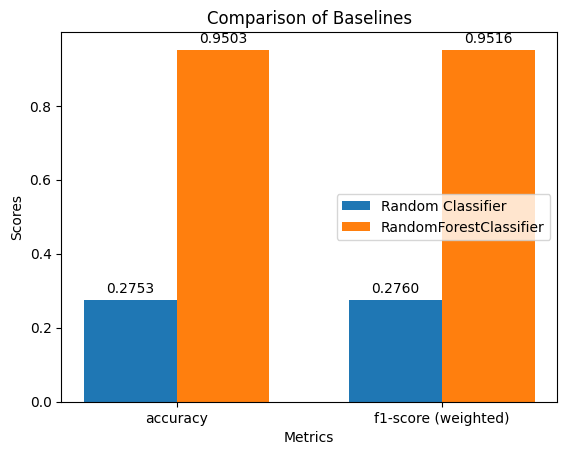

In [18]:
baseline_metrics = ['accuracy', 'f1-score (weighted)']
random_classifier_scores = [0.2753, 0.2760]
random_forest_scores = [0.9503, 0.9516]

x = np.arange(len(baseline_metrics))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, random_classifier_scores, width, label='Random Classifier')
bars2 = ax.bar(x + width/2, random_forest_scores, width, label='RandomForestClassifier')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Baselines')
ax.set_xticks(x)
ax.set_xticklabels(baseline_metrics)
ax.legend()

def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(bars1)
add_values(bars2)

plt.show()


<div class="alert alert-block alert-info">
<b>Baselines for Comparisions:</b>

- As expected 'Random Classifier' showed modest performance with an average accuracy of 0.2362 and an average f1-score of 0.2358, while the 'RandomForestClassifier' classified the dataset strongly, achieving 95.03% accuracy and a well-balanced f1-score(95.16%) that considers both precision and recall.

-  While RandomForestClassifier excels with high accuracy and f1-score, demonstrating robust performance in classification tasks, there exists an probability and opportunity to explore deeper neural networks to achieve even higher accuracy levels beyond 95%.

## **6. TASK 6 - DEEP LEARNING EXPERIMENTS**

i. Building Deep Learning Models up:
- Mainly, I used Convolutional Neural Network(CNN) architecture and created two diffrent Deep Learning Models called 'SimpleCNN' and 'MultiLayerCNN'.

  - The 'SimpleCNN' model comprises a single convolutional layer with 8 filters of size 3x3 with padding of 1 to maintain spatial dimensions followed by max pooling, designed for basic image classification tasks with 3 input channels and output mapped to 4 classes.
  
  - The 'MultiLayerCNN' model features six convolutional layers with increasing complexity and max pooling operations, followed by flattening and a fully connected layer mapping input from 3 channels to 16 channels, and then to 4 output classes.
- Later on, I created another model called 'OptMultiLayerCNN' to optimize the 'MultiLayerCNN' model based on the creteria specified in the **portfolio.pdf** which is; *Choose at least one of the architectures such that it contains layers or cells beyond simple linear layers and activation functions.*

  - The 'OptMultiLayerCNN' model is an optimized version of 'MultiLayerCNN', featuring the addition of dropout layers with a dropout probability of 0.3 after conv3 and conv5. The activation functions have been updated to Parametric ReLU (PReLU) for potential improvement in learning capabilities. These modifications aim to enhance regularization during training, mitigating overfitting and potentially improving generalization on unseen data.


- I also created an additional basic model named 'SingleLayerCNN', which comprises two fundamental layers: a single convolutional layer followed by a max pooling layer. This model was designed to provide only a straightforward interpretation of how CNN architectures with minimal layers can process the image datasets.


In [19]:
class SingleLayerCNN(nn.Module):
    def __init__(self):
        super(SingleLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        return x

single_layer_cnn = SingleLayerCNN()

image.shape : torch.Size([20, 3, 64, 64])
out.shape : torch.Size([20, 8, 32, 32])
label : tensor(1)


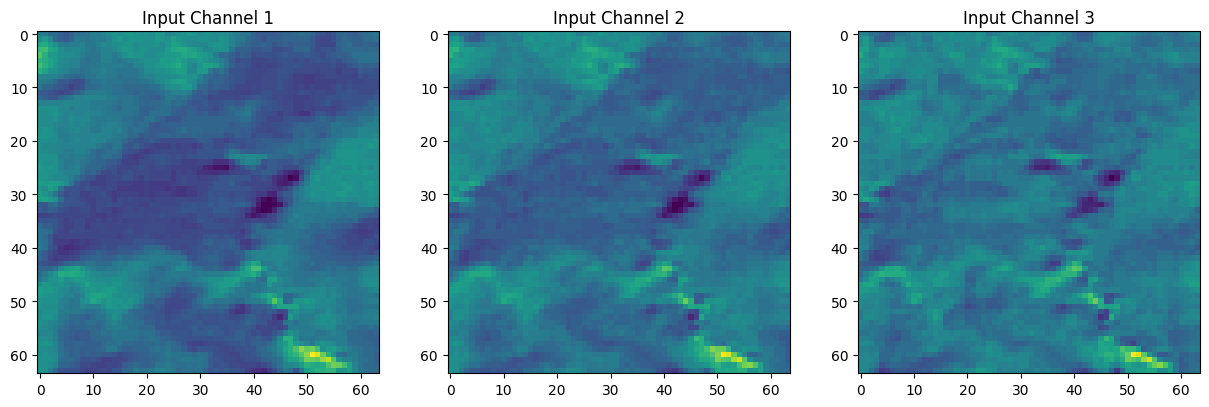

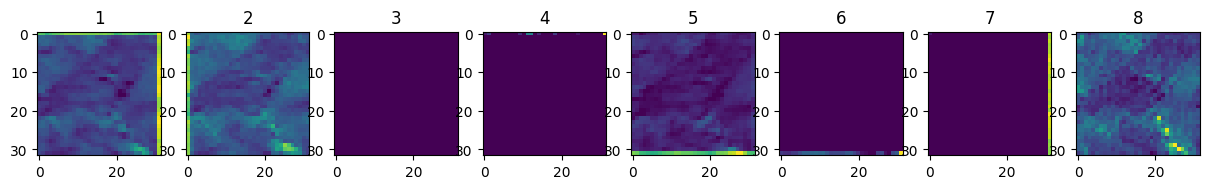

In [20]:
def visualize_channels(images, out, labels):
    images_plot = images.detach().cpu().numpy()
    out_plot = out.detach().cpu().numpy()

    fig, ax = plt.subplots(1, len(images_plot[0]), figsize=(15, 5))
    for i in range(len(images_plot[0])):
        ax[i].imshow(images_plot[0][i])
        ax[i].set_title(f'Input Channel {i+1}')
    plt.show()

    fig, ax = plt.subplots(1, len(out_plot[0]), figsize=(15, 15))
    for i in range(len(out_plot[0])):
        ax[i].imshow(out_plot[0][i])
        ax[i].set_title(f'{i+1}')
    plt.show()

out = single_layer_cnn(images)

print('image.shape :', images.shape)
print('out.shape :', out.shape)
print('label :', labels[0])

visualize_channels(images, out, labels)

- The Conv2d layer converts a 3-channel image into an 8-channel feature map, and the MaxPool2d layer reduces its height and width.
- As we add more layers, the feature maps progressively shrink until we end up with small (nx1x1) maps. Here, 'n' signifies the number of channels, forming a condensed representation that can be flattened into a vector.
- After flattening the small feature maps into vectors, we integrate them through fully connected layers to obtain a 4-element vector for each image.

In [33]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv_out_size = self._get_conv_output_size()
        
        self.fc = nn.Linear(self.conv_out_size, num_classes)
        
    def _get_conv_output_size(self):
        x = torch.randn(1, 3, 64, 64)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        conv_out_size = x.size(1) * x.size(2) * x.size(3)
        return conv_out_size
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

simple_cnn = SimpleCNN()

In [34]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 16, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 16, 3, 1, 1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(16, 16, 3, 1, 1)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(16, 16, 3, 1, 1)
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(2, 2)
        
        self.conv6 = nn.Conv2d(16, 16, 3, 1, 1)
        self.relu6 = nn.ReLU()
        self.maxpool6 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.maxpool6(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        
        return x
    
model = MultiLayerCNN()

In [35]:
class OptMultiLayerCNN(nn.Module):
    def __init__(self):
        super(OptMultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 16, 3, 1, 1)
        self.relu2 = nn.PReLU() # Using PReLU() instead ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 16, 3, 1, 1)
        self.relu3 = nn.PReLU() # Using PReLU() instead ReLU()
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(p=0.3)  # Adding dropout after conv3
        
        self.conv4 = nn.Conv2d(16, 16, 3, 1, 1)
        self.relu4 = nn.PReLU() # Using PReLU() instead ReLU()
        self.maxpool4 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(16, 16, 3, 1, 1)
        self.relu5 = nn.PReLU() # Using PReLU() instead ReLU()
        self.maxpool5 = nn.MaxPool2d(2, 2)
        self.dropout5 = nn.Dropout(p=0.3)  # Adding dropout after conv5
        
        self.conv6 = nn.Conv2d(16, 16, 3, 1, 1)
        self.relu6 = nn.PReLU() # Using PReLU() instead ReLU()
        self.maxpool6 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)  # Applying dropout after conv3
        
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        x = self.dropout5(x)  # Applying dropout after conv5
        
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.maxpool6(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        
        return x

opt_model = OptMultiLayerCNN()


ii. Creating the Functions for Training, Evaluating, and Monitoring Deep Learning Models in Classification Task:

- 'loss_batch' function computes the loss and optional metrics for a batch of data during training.
  - It takes as input the model, loss function, input batch (xb), target batch (yb), optimizer (opt), and metrics. It computes predictions using the model, calculates the loss using the loss function, and optionally computes metrics such as accuracy or f1-score.
  - It sets the model in training mode and performs backpropagation if an optimizer is provided. In this experiment, 'torch.optim.Adam' is selected as the optimizer.
  - It returns the loss as a scalar, number of samples in the batch, and results of metrics(ccuracy or f1-score) if computed.

- 'evaluate' function evaluates the model on a validation dataset.
  - It sets the model to evaluation mode, computes losses and metrics across all batches in the validation dataset without computing gradients.
  - It returns the average loss across all batches, total number of samples, and average metrics (such as accuracy or f1-score) if specified.

- 'accuracy' and 'f1_score_metric' funtcions compute the accuracy and f1-score metrics respectively.
  - They both take predicted outputs and true labels, computes predictions by taking the argmax of outputs. 'accuracy' function compares them to labels to calculate accuracy and 'f1_score_metric' function calculates the f1-score using the f1_score function from sklearn.metrics.
  - They both return the metrics as a tensor.

- 'fit' function trains the model for a specified number of epochs, evaluating it on a validation dataset and implementing early stopping.
  - It iterates over epochs, performing training and evaluation phases. It computes losses and metrics for both training and validation datasets, updates model parameters using the specified optimizer, and monitors validation loss for early stopping.
  - It stops training early if validation loss does not improve for a specified number of epochs (patience).
  - It returns lists of training and validation losses, and lists of training and validation metrics computed during each epoch.


In [36]:
def loss_batch(model, loss_func, xb, yb, opt=None, metrics=None):
    model.train() 
    preds = model(xb)
    loss = loss_func(preds, yb)

    if opt is not None:
        loss.backward() 
        opt.step()       
        opt.zero_grad()  

    metric_results = [None] * len(metrics)
    if metrics is not None:
        for i, metric in enumerate(metrics):
            metric_results[i] = metric(preds, yb)

    return loss.item(), len(xb), metric_results


In [37]:
def evaluate(model, loss_fn, valid_dl, metrics=None):
    model.eval() 
    with torch.no_grad():
        results = []
        for xb, yb in valid_dl:
            losses, nums, metrics_results = loss_batch(model, loss_fn, xb, yb, metrics=metrics)
            results.append((losses, nums, metrics_results))

        losses, nums, metrics_results = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metrics = [np.sum(np.multiply(metric_results, nums)) / total for metric_results in zip(*metrics_results)]

    return avg_loss, total, avg_metrics


In [38]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [39]:
from sklearn.metrics import f1_score

def f1_score_metric(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(f1_score(labels.cpu(), preds.cpu(), average='weighted'))

In [40]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, opt_fn=None, lr=None, metrics=None, patience=3):
    set_seeds()  # Set seeds for reproducibility

    train_losses, val_losses = [], []
    train_metrics, val_metrics = [[] for _ in range(len(metrics))], [[] for _ in range(len(metrics))]

    if opt_fn is None:
        opt_fn = torch.optim.Adam  # Default optimizer if not specified
    opt = opt_fn(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_train_losses = []
        epoch_train_metrics = [[] for _ in range(len(metrics))]
        for xb, yb in train_dl:
            train_loss, _, train_metric = loss_batch(model, loss_fn, xb, yb, opt, metrics=metrics)
            epoch_train_losses.append(train_loss)
            for i, metric in enumerate(metrics):
                epoch_train_metrics[i].append(train_metric[i].item())
        train_losses.append(np.mean(epoch_train_losses))
        for i in range(len(metrics)):
            train_metrics[i].append(np.mean(epoch_train_metrics[i]))

        # Evaluation
        model.eval()
        with torch.no_grad():
            epoch_val_losses = []
            epoch_val_metrics = [[] for _ in range(len(metrics))]
            for xb, yb in valid_dl:
                val_loss, _, val_metric = loss_batch(model, loss_fn, xb, yb, metrics=metrics)
                epoch_val_losses.append(val_loss)
                for i, metric in enumerate(metrics):
                    epoch_val_metrics[i].append(val_metric[i].item())
            val_losses.append(np.mean(epoch_val_losses))
            for i in range(len(metrics)):
                val_metrics[i].append(np.mean(epoch_val_metrics[i]))

        # Early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping after epoch {epoch + 1}')
            break

        metric_str = ', '.join([f'{metrics[i].__name__}: {val_metrics[i][-1]:.4f}' for i in range(len(metrics))])
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {val_losses[-1]:.4f}, {metric_str}')

    return train_losses, val_losses, train_metrics, val_metrics

iii. Training, Evaluation, and Visualization of each Deep Learning Models:
- In this step, I aimed to compare these models to identify which architecture performs best for the given image classification task. The use of visualization helps in understanding how each model's performance evolves during training and how well they generalize to unseen data(validation set) before the final evaluation the test set.

In [41]:
#Typical Hyperparameters:

num_epochs = 30 # All models were trained for a maximum of 30 epochs
lr = 0.001
opt_fn = torch.optim.Adam

In [42]:
simple_cnn_eva = fit(num_epochs, simple_cnn, F.cross_entropy, train_deep, val_deep, opt_fn, lr, metrics=[f1_score_metric, accuracy])
train_losses_simple, val_losses_simple, train_metrics_simple, val_metrics_simple = simple_cnn_eva

Epoch [1/30], Loss: 0.2978, f1_score_metric: 0.8639, accuracy: 0.8672
Epoch [2/30], Loss: 0.2409, f1_score_metric: 0.9036, accuracy: 0.9034
Epoch [3/30], Loss: 0.3625, f1_score_metric: 0.8140, accuracy: 0.8259
Epoch [4/30], Loss: 0.2356, f1_score_metric: 0.8928, accuracy: 0.8948
Epoch [5/30], Loss: 0.2184, f1_score_metric: 0.8959, accuracy: 0.8983
Epoch [6/30], Loss: 0.2388, f1_score_metric: 0.9133, accuracy: 0.9109
Epoch [7/30], Loss: 0.1964, f1_score_metric: 0.9250, accuracy: 0.9259
Epoch [8/30], Loss: 0.1570, f1_score_metric: 0.9528, accuracy: 0.9534
Epoch [9/30], Loss: 0.1697, f1_score_metric: 0.9369, accuracy: 0.9333
Epoch [10/30], Loss: 0.1495, f1_score_metric: 0.9501, accuracy: 0.9471
Epoch [11/30], Loss: 0.2155, f1_score_metric: 0.9025, accuracy: 0.9052
Epoch [12/30], Loss: 0.3385, f1_score_metric: 0.8106, accuracy: 0.8190
Epoch [13/30], Loss: 0.1406, f1_score_metric: 0.9495, accuracy: 0.9500
Epoch [14/30], Loss: 0.1898, f1_score_metric: 0.9182, accuracy: 0.9161
Epoch [15/30], 

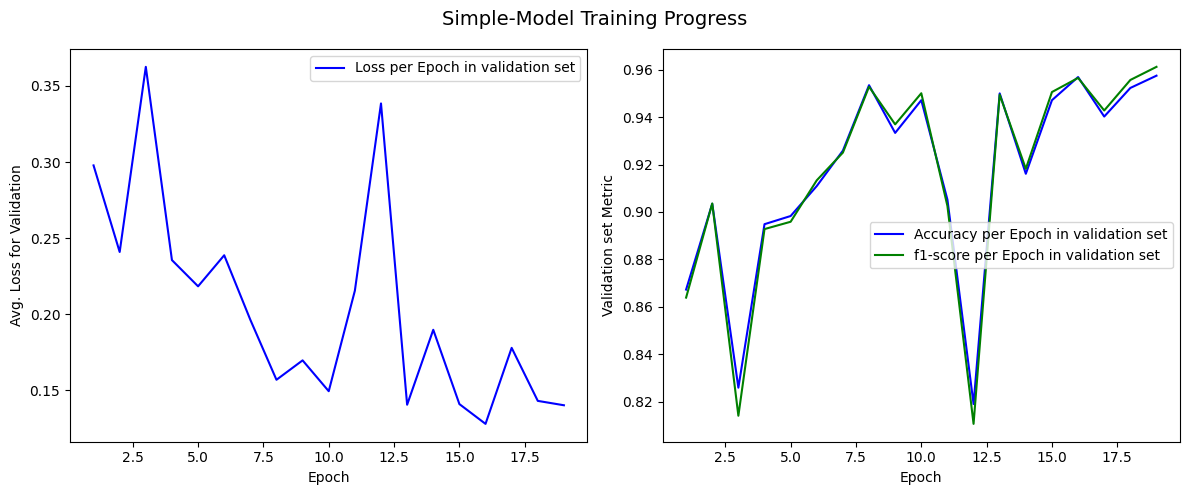

In [43]:
epoch_array_simple_cnn = np.linspace(1, len(val_losses_simple), len(val_losses_simple))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_array_simple_cnn, val_losses_simple, 'b-', label='Loss per Epoch in validation set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss for Validation')

plt.subplot(1, 2, 2)
plt.plot(epoch_array_simple_cnn, np.array(val_metrics_simple[1]), 'b-', label='Accuracy per Epoch in validation set')
plt.plot(epoch_array_simple_cnn, np.array(val_metrics_simple[0]), 'g-', label='f1-score per Epoch in validation set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation set Metric')
plt.suptitle('Simple-Model Training Progress', fontsize=14)
plt.tight_layout()

plt.show()

- Initial Improvement: Epochs 1-8 demonstrate consistent improvement in both validation loss and metrics (f1-score and accuracy). The loss decreases notably from 0.2978 to 0.1570, while the f1-score increases from 0.8639 to 0.9528 and accuracy improves from 0.8672 to 0.9534. This phase indicates effective learning and better performance on the validation set as the model adapts to the data.

- Performance Fluctuation: In epochs 9-11, minor fluctuations occur where there is a slight increase in loss and temporary drops in f1-score and accuracy. However, the overall trend remains positive, with subsequent epochs showing recovery in performance metrics.

- Overfitting Indicators: Epochs 12-13 and 17-18 show noticeable increases in validation loss (e.g., 0.3385 in epoch 12 and 0.1779 in epoch 17), accompanied by drops in both f1-score and accuracy. These indicators suggest potential overfitting, where the model starts to memorize training data rather than generalizing well to unseen data.

- Consistent Performance: During epochs 14-16, the model exhibits strong and consistent performance with low validation losses (e.g., 0.1410 in epoch 15 and 0.1280 in epoch 16) and high f1-scores and accuracies (e.g., f1-score of 0.9506 and accuracy of 0.9471 in epoch 15). This phase highlights the model's ability to generalize well on the validation set.

- Early Stopping: Epoch 19 triggers early stopping, indicating that the model's validation loss did not improve for several epochs. This decision helps prevent overfitting and conserves computational resources by halting training when further iterations are unlikely to improve performance.

These phases illustrate the model's learning journey, from initial improvement and minor fluctuations to handling overfitting indicators and ultimately achieving consistent performance before deciding to halt training to avoid overfitting.

In [44]:
ml_cnn_eva = fit(num_epochs, model, F.cross_entropy, train_deep, val_deep, opt_fn, lr, metrics=[f1_score_metric, accuracy])
train_losses_ml_cnn, val_losses_ml_cnn, train_metrics_ml_cnn, val_metrics_ml_cnn = ml_cnn_eva

Epoch [1/30], Loss: 0.4430, f1_score_metric: 0.7018, accuracy: 0.7420
Epoch [2/30], Loss: 0.3969, f1_score_metric: 0.7838, accuracy: 0.7902
Epoch [3/30], Loss: 0.3838, f1_score_metric: 0.8211, accuracy: 0.8287
Epoch [4/30], Loss: 0.2799, f1_score_metric: 0.9013, accuracy: 0.9034
Epoch [5/30], Loss: 0.2955, f1_score_metric: 0.8862, accuracy: 0.8851
Epoch [6/30], Loss: 0.2518, f1_score_metric: 0.9195, accuracy: 0.9161
Epoch [7/30], Loss: 0.2610, f1_score_metric: 0.9057, accuracy: 0.9023
Epoch [8/30], Loss: 0.2674, f1_score_metric: 0.9184, accuracy: 0.9144
Epoch [9/30], Loss: 0.2146, f1_score_metric: 0.9095, accuracy: 0.9057
Epoch [10/30], Loss: 0.1685, f1_score_metric: 0.9389, accuracy: 0.9397
Epoch [11/30], Loss: 0.1782, f1_score_metric: 0.9294, accuracy: 0.9264
Epoch [12/30], Loss: 0.2690, f1_score_metric: 0.9243, accuracy: 0.9213
Early stopping after epoch 13


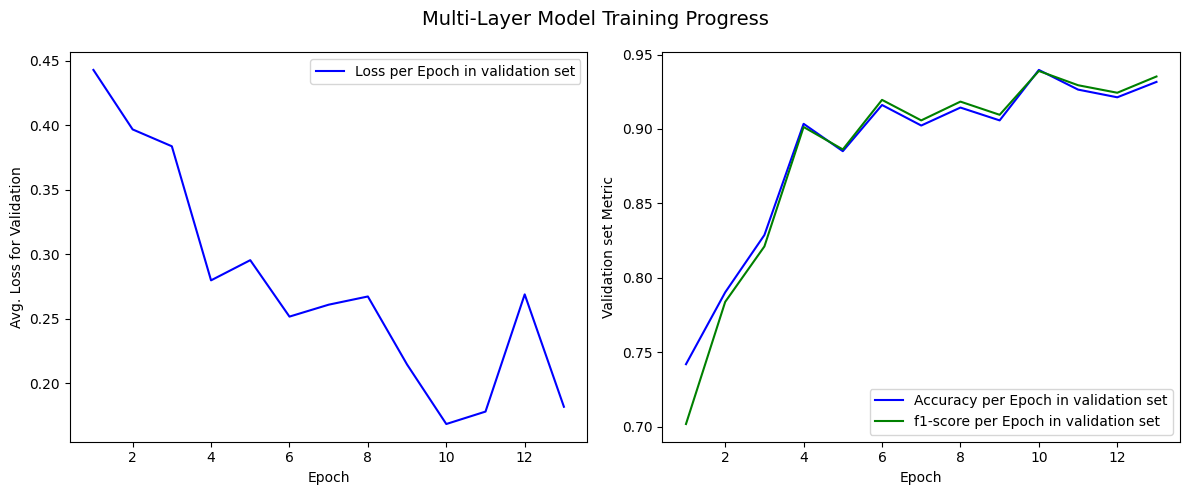

In [45]:
epoch_array_ml_cnn = np.linspace(1, len(val_losses_ml_cnn), len(val_losses_ml_cnn))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_array_ml_cnn, val_losses_ml_cnn, 'b-', label='Loss per Epoch in validation set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss for Validation')

plt.subplot(1, 2, 2)
plt.plot(epoch_array_ml_cnn, np.array(val_metrics_ml_cnn[1]), 'b-', label='Accuracy per Epoch in validation set')
plt.plot(epoch_array_ml_cnn, np.array(val_metrics_ml_cnn[0]), 'g-', label='f1-score per Epoch in validation set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation set Metric')
plt.suptitle('Multi-Layer Model Training Progress', fontsize=14) 
plt.tight_layout()

plt.show()

- Initial Learning Phase: Significant improvement is seen from epochs 1-3, with validation loss decreasing from 0.4430 to 0.3838, and both f1-score and accuracy showing notable increases. This indicates effective learning and better performance on the validation set early on.

- Strong Performance: Continuing from epochs 4-6, the model maintains strong performance, achieving a validation loss of 0.2518 in epoch 6, with high f1-score and accuracy. This phase demonstrates consistent learning and effective generalization.

- Minor Fluctuations: Epochs 7-8 show minor fluctuations in validation loss and metrics, but overall performance remains robust. For instance, in epoch 8, the loss is 0.2674, f1-score is 0.9184, and accuracy is 0.9144.

- Further Improvement: From epochs 9-11, the model exhibits further improvement, reaching a validation loss of 0.1685 in epoch 10, and achieving peak f1-score and accuracy. These results indicate continued strong performance on the validation set.

- Early Signs of Overfitting: In epochs 12-13, a slight increase in validation loss and minor fluctuations in metrics suggest early signs of overfitting. Early stopping is triggered after epoch 13 due to the validation loss no longer showing improvement, indicating that further training could lead to overfitting.

These phases illustrate the model's learning trajectory, starting with significant improvement, maintaining strong performance, minor fluctuations, further improvement, and addressing early signs of overfitting through early stopping.

In [46]:
opt_model_eva = fit(num_epochs, opt_model, F.cross_entropy, train_deep, val_deep, opt_fn, lr, metrics=[f1_score_metric, accuracy])
train_losses_opt_model, val_losses_opt_model, train_metrics_opt_model, val_metrics_opt_model = opt_model_eva

Epoch [1/30], Loss: 0.6752, f1_score_metric: 0.4989, accuracy: 0.5379
Epoch [2/30], Loss: 0.3949, f1_score_metric: 0.7786, accuracy: 0.8069
Epoch [3/30], Loss: 0.3011, f1_score_metric: 0.8880, accuracy: 0.8879
Epoch [4/30], Loss: 0.2296, f1_score_metric: 0.9015, accuracy: 0.9034
Epoch [5/30], Loss: 0.2034, f1_score_metric: 0.9203, accuracy: 0.9207
Epoch [6/30], Loss: 0.2109, f1_score_metric: 0.9160, accuracy: 0.9172
Epoch [7/30], Loss: 0.2149, f1_score_metric: 0.9056, accuracy: 0.9069
Early stopping after epoch 8


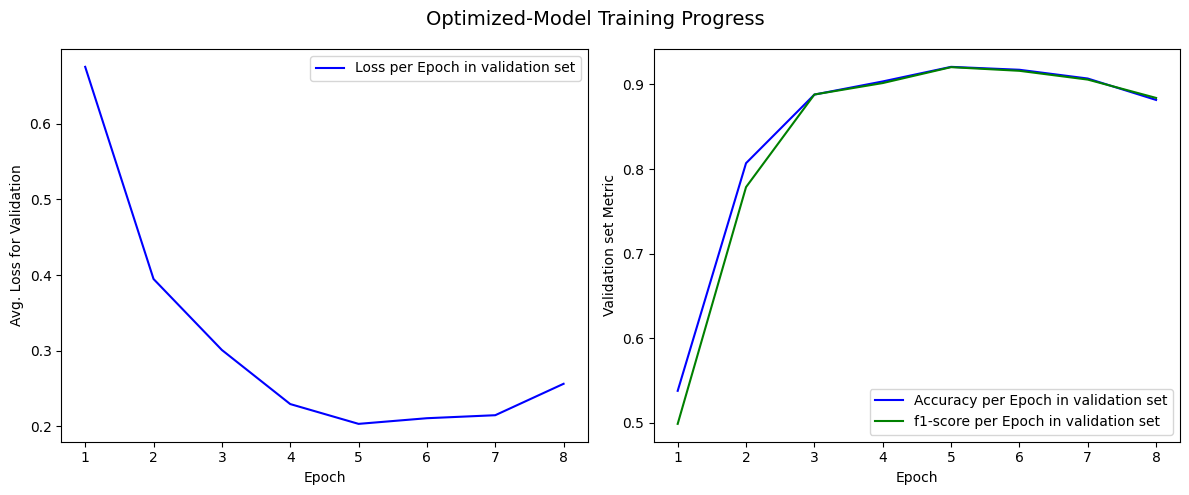

In [47]:
epoch_array_opt_model = np.linspace(1, len(val_losses_opt_model), len(val_losses_opt_model))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_array_opt_model, val_losses_opt_model, 'b-', label='Loss per Epoch in validation set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss for Validation')

plt.subplot(1, 2, 2)
plt.plot(epoch_array_opt_model, np.array(val_metrics_opt_model[1]), 'b-', label='Accuracy per Epoch in validation set')
plt.plot(epoch_array_opt_model, np.array(val_metrics_opt_model[0]), 'g-', label='f1-score per Epoch in validation set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation set Metric')
plt.suptitle('Optimized-Model Training Progress', fontsize=14)  
plt.tight_layout()

plt.show()

- Initial Learning Phase: The model starts with high validation loss and relatively low f1-score and accuracy, indicating challenges in learning from the data initially.

- Rapid Improvement: Substantial improvement occurs in epochs 2-3, with significant decreases in validation loss and notable increases in f1-score and accuracy, suggesting rapid learning and generalization.

- Stable Performance: From epochs 4-5, the model maintains strong and consistent performance, achieving lower validation loss and high f1-score and accuracy, indicating stable learning and generalization.

- Slight Fluctuations and Early Stopping: Minor fluctuations in validation loss, f1-score, and accuracy are observed in epochs 6-7. Early stopping is triggered after epoch 8 due to the validation loss plateauing, signaling that further training would not significantly improve performance.

These observations highlight the dynamic nature of model training, showing phases of initial struggle, rapid improvement, stable performance, and eventual early stopping based on validation metrics.


iv. The final Model Evaluation on Test Dataset
- I finally completed the Task 6 by evaluating the trained models (Simple Model, Multi-Layer Model, and Optimized Model) on the test dataset and visualized their performance metrics.

In [48]:
test_loader = DataLoader(test_dataset, batch_size=20)
metrics=[f1_score_metric, accuracy]

In [49]:
torch.save(simple_cnn.state_dict(), 'simple_model.pth')#I saved trained DL model(SimpleCNN),I attached the file in the zipfolder in case you wanna see it
model_simple = simple_cnn
model_simple.load_state_dict(torch.load('simple_model.pth'), strict=False) # Here I uploaded the trained DL model back to perform it on the test set

result_simple_cnn = evaluate(model_simple, F.cross_entropy, test_loader, metrics=metrics)
test_loss_simple_cnn, _, test_metrics_simple_cnn = result_simple_cnn

print('The Avg. loss in test dataset for the simple model = ', round(test_loss_simple_cnn, 3))
print('The Avg. accuracy in test dataset for the simple model = ', round( test_metrics_simple_cnn[0], 3))
print('The Avg. f1-score in test dataset for the simple model = ', round( test_metrics_simple_cnn[1], 3))

The Avg. loss in test dataset for the simple model =  0.136
The Avg. accuracy in test dataset for the simple model =  0.965
The Avg. f1-score in test dataset for the simple model =  0.964


In [50]:
torch.save(model.state_dict(), 'ml_cnn_model.pth')#I saved the trained DL model(MultiLayerCNN),I attached the file in the zipfolder in case you wanna see it
model_ml_cnn = model
model_ml_cnn.load_state_dict(torch.load('ml_cnn_model.pth'), strict=False) # Here I uploaded the trained DL model back to perform it on the test set

result_ml_cnn = evaluate(model_ml_cnn, F.cross_entropy, test_loader, metrics=metrics)
test_loss_ml_cnn, _, test_metrics_ml_cnn = result_ml_cnn

print('The Avg. loss in test dataset for the multi-layer model = ', round(test_loss_ml_cnn, 3))
print('The Avg. accuracy in test dataset for the multi-layer model = ', round( test_metrics_ml_cnn[0], 3))
print('The Avg. f1-score in test dataset for the multi-layer model = ', round( test_metrics_ml_cnn[1], 3))

The Avg. loss in test dataset for the multi-layer model =  0.219
The Avg. accuracy in test dataset for the multi-layer model =  0.929
The Avg. f1-score in test dataset for the multi-layer model =  0.929


In [51]:
torch.save(model.state_dict(), 'opt_model.pth')#I saved the trained DL model(OptMultiLayerCNN),I attached the file in the zipfolder in case you wanna see it
model_opt = opt_model
model_opt.load_state_dict(torch.load('opt_model.pth'), strict=False) # Here I uploaded the trained DL model back to perform it on the test set

result_opt= evaluate(model_opt, F.cross_entropy, test_loader, metrics=metrics)
test_loss_opt, _, test_metrics_opt = result_opt

print('The Avg. loss in test dataset for the optimized model = ', round(test_loss_opt, 3))
print('The Avg. accuracy in test dataset for the optimized model = ', round( test_metrics_opt[0], 3))
print('The Avg. f1-score in test dataset for the optimized model = ', round( test_metrics_opt[1], 3))

The Avg. loss in test dataset for the optimized model =  0.42
The Avg. accuracy in test dataset for the optimized model =  0.905
The Avg. f1-score in test dataset for the optimized model =  0.904


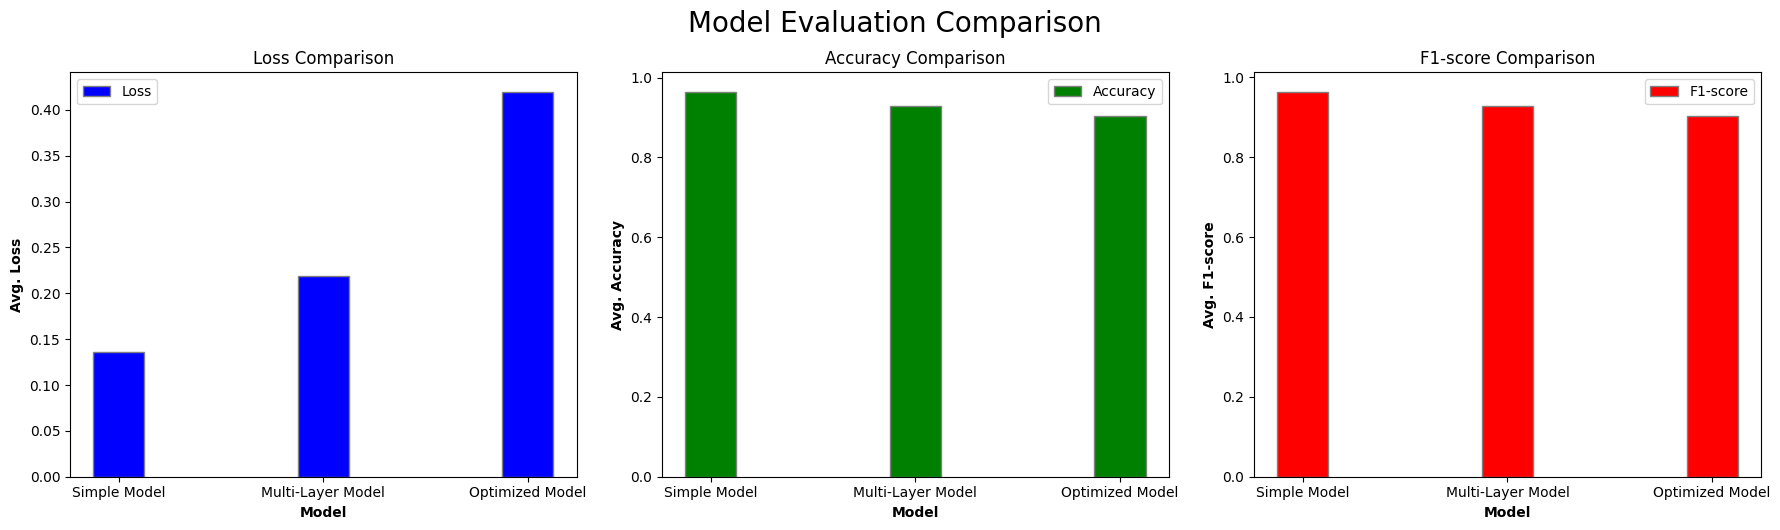

In [58]:
models = ['Simple Model', 'Multi-Layer Model', 'Optimized Model']
losses = [0.136, 0.219, 0.42]
accuracies = [0.965, 0.929, 0.905]
f1_scores = [0.964, 0.929, 0.904]

bar_width = 0.25

r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].bar(r1, losses, color='b', width=bar_width, edgecolor='grey', label='Loss')
ax[0].set_xlabel('Model', fontweight='bold')
ax[0].set_ylabel('Avg. Loss', fontweight='bold')
ax[0].set_title('Loss Comparison')
ax[0].set_xticks(r1)
ax[0].set_xticklabels(models)
ax[0].legend()

ax[1].bar(r1, accuracies, color='g', width=bar_width, edgecolor='grey', label='Accuracy')
ax[1].set_xlabel('Model', fontweight='bold')
ax[1].set_ylabel('Avg. Accuracy', fontweight='bold')
ax[1].set_title('Accuracy Comparison')
ax[1].set_xticks(r1)
ax[1].set_xticklabels(models)
ax[1].legend()

ax[2].bar(r1, f1_scores, color='r', width=bar_width, edgecolor='grey', label='F1-score')
ax[2].set_xlabel('Model', fontweight='bold')
ax[2].set_ylabel('Avg. F1-score', fontweight='bold')
ax[2].set_title('F1-score Comparison')
ax[2].set_xticks(r1)
ax[2].set_xticklabels(models)
ax[2].legend()

plt.tight_layout()
plt.suptitle('Model Evaluation Comparison', fontsize=20, y=1.05)
plt.show()


<div class="alert alert-block alert-info">
<b>Evaluation of the Models:</b>

- Simple-Model(SimpleCNN) achieved the lowest average loss among the three models, indicating it made the least amount of errors when predicting on unseen data. It also achieved the highest accuracy and f1-score, suggesting it performed exceptionally well in both correctly classifying instances and balancing precision and recall.

- Multi-Layer Model(MultiLayerCNN) shows slightly higher average loss compared to the Simple Model, indicating it made more errors during predictions. The accuracy and f1-score are also slightly lower than those of the Simple Model, suggesting it performed slightly less effectively in correctly classifying instances and maintaining a balance between precision and recall.

- Optimized-Model(OptMultiLayerCNN) exhibits the highest average loss among the three models, indicating it made more prediction errors compared to the Simple and Multi-Layer Models. The accuracy and f1-score are also lower, suggesting it performed less effectively in both classification accuracy and overall predictive performance.

- I initially implemented two different baselines to evaluate the image classification problem: a simple classification baseline using a Random Classifier, and a classical machine learning algorithm, RandomForestClassifier. The RandomForestClassifier achieved a notable accuracy of 95.03% and an f1-score of 95.15% with less computational time. However, achieving higher accuracy becomes challenging with traditional machine learning methods. Therefore, leveraging deep learning, the Simple-Model (SimpleCNN), a convolutional neural network architecture, played a crucial role in achieving even higher accuracy, reaching up to 96.5% accuracy and 96.4% f1-score.


## **7. TASK 7 - CONCLUSIONS and FUTURE WORK**

<div class="alert alert-block alert-info">
<b></b>

*1. Summarize and interpret the achieved results:*

From the conducted deep learning experiments on the RSI-CB256 dataset using various CNN architectures (SimpleCNN, MultiLayerCNN, and OptMultiLayerCNN), the following results were observed on the test dataset:

-->SimpleCNN:

Average Loss: 0.136 - Average Accuracy: 96.5% - Average f1-score: 96.4%

-->MultiLayerCNN:

Average Loss: 0.219 - Average Accuracy: 92.9% - Average f1-score: 92.9%

-->OptMultiLayerCNN:

Average Loss: 0.42 - Average Accuracy: 90.5% - Average f1-score: 90.4%

- The SimpleCNN model outperformed both the MultiLayerCNN and OptMultiLayerCNN models in terms of average loss, accuracy, and f1-score on the test dataset.

- The MultiLayerCNN, despite its deeper architecture, showed slightly lower performance metrics compared to SimpleCNN model, indicating a trade-off between model complexity and performance.

- The OptMultiLayerCNN, although optimized with additional layers and dropout, unexpectedly demonstrated the highest average loss and slightly lower accuracy and f1-score. Furthermore, It did not achieve better performance than the simpler models, indicating potential overfitting or suboptimal hyperparameter tuning and suggesting room for further improvement or fine-tuning.

This suggests that for this particular image classification task, a simpler model architecture can achieve higher accuracy and better generalization.

*2. Recommend a course of action for the organization in your story based on the results of Task 6:*

Based on the results:

At EMA (Environmental Monitoring Agency) we should prioritize deploying the SimpleCNN model for operational use. It demonstrates the highest accuracy and f1-score among the models evaluated. This model can effectively classify satellite images into 'cloudy', 'desert', 'green_area', and 'water' categories, which are crucial for monitoring urban heat spots, water quality, and changes in vegetation.

*3. Reflect on limitations and possible pitfalls of using these results:*

- The dataset size (5631 images) might be considered relatively small for deep learning experiments, potentially limiting the generalizability of models to unseen data.

- Model Complexity: Deeper models like MultiLayerCNN and OptMultiLayerCNN did not necessarily improve performance over the simpler SimpleCNN, suggesting careful consideration of model complexity versus performance trade-offs.

- Hyperparameter Tuning: Limited exploration of hyperparameters (aside from architecture changes in the optimized model) might have restricted the models from achieving their full potential.

*4. Critically discuss the employed methodology (your choices as well as the choices given in these tasks). What could or even should have been done differently?*

Methodology Evaluation:

- Data Handling: The choice of ImageFolder and torchvision for data loading and preprocessing was appropriate. However, exploring data augmentation techniques (like rotation, flipping) could further enhance model robustness.

- Model Selection: Starting with SimpleCNN and progressing to more complex models was a logical approach. However, more comprehensive hyperparameter tuning and regularization techniques could have been employed to optimize performance.

- Evaluation Metrics: While accuracy and f1-score were used for evaluation, considering additional metrics like precision, recall, and confusion matrices could provide deeper insights into model performance across different classes.

*5. Propose ideas for future work (a short sketch or enumeration of ideas is sufficient, no further experiments).*

Future Work Ideas:

- Transfer Learning: Explore pre-trained models (e.g., ResNet, VGG) and fine-tune them on the RSI-CB256 dataset. Transfer learning can leverage features learned from larger datasets, potentially improving performance with less training data.

- Ensemble Methods: Combine predictions from multiple models (e.g., SimpleCNN, MultiLayerCNN) to leverage diverse model architectures and improve overall classification accuracy.

- Advanced Regularization: Implement advanced regularization techniques such as batch normalization, weight decay, and learning rate scheduling to mitigate overfitting and improve model generalization.

- Spatial-Temporal Modeling: Incorporate temporal information from satellite images over time to capture dynamic environmental changes, complementing the existing spatial features.

These ideas aim to enhance model performance, address limitations identified, and explore new avenues for leveraging deep learning in environmental monitoring applications.